In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import torch

from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

In [2]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.05, 0.05
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1


# coordinate transformation
pj_tmerc = f"+proj=tmerc +lon_0={(lon_min+lon_max)/2} +k=1.00010001 +ellps=WGS84 +datum=WGS84 +no_defs"
pj_latlong = "+proj=latlong +ellps=WGS84 +datum=WGS84 +no_defs"
ll2xy = pyproj.Transformer.from_proj(pj_latlong, pj_tmerc, always_xy=True)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x, y = ll2xy.transform(Lon, Lat)
X = torch.from_numpy(x/1e3) # km
Y = torch.from_numpy(y/1e3) # km

z = np.zeros_like(x)
Z = torch.from_numpy(z)


# source parameters
lat_ref = 40.2224
lon_ref = 144.8678
x_ref, y_ref = ll2xy.transform(lon_ref, lat_ref)


# specify `requires_grad=True`
x_ref = torch.tensor(x_ref/1e3, requires_grad=True) # km
y_ref = torch.tensor(y_ref/1e3, requires_grad=True) # km
depth = torch.tensor(0.1, requires_grad=True) # km
length = torch.tensor(218.0, requires_grad=True) # km
width = torch.tensor(46.0, requires_grad=True) # km
dip = torch.tensor(60.0, requires_grad=True)
strike = torch.tensor(189.0, requires_grad=True)
rake = torch.tensor(270.0, requires_grad=True)
slip = torch.tensor(5.62, requires_grad=True)

In [3]:
coords = {
    "x": X,
    "y": Y,
    "z": Z
}
params = {
    "x_ref": x_ref,
    "y_ref": y_ref,
    "depth": depth,
    "length": length,
    "width": width,
    "strike": strike,
    "dip": dip,
    "rake": rake,
    "slip": slip
}

# Diagonal hessian of `ux`, `uy` and `uz` with respect to `x`, `y` and `z`

Note: In the following, `uijk` means $\dfrac{\partial^2 u_i}{\partial x_j \partial x_k}$

In [10]:
# as the gradient of strain
uxx, uyx, uzx, uxxx, uyxx, uzxx, uxyx, uyyx, uzyx, uxzx, uyzx, uzzx = okada.gradient(
    coords, params, arg="x", compute_strain=True, is_degree=True
)
uxy, uyy, uzy, uxxy, uyxy, uzxy, uxyy, uyyy, uzyy, uxzy, uyzy, uzzy = okada.gradient(
    coords, params, arg="y", compute_strain=True, is_degree=True
)
uxz, uyz, uzz, uxxz, uyxz, uzxz, uxyz, uyyz, uzyz, uxzz, uyzz, uzzz = okada.gradient(
    coords, params, arg="z", compute_strain=True, is_degree=True
)

# as the hessian of displacement
UXXX, UYXX, UZXX = okada.hessian(coords, params, arg1="x", arg2="x", compute_strain=False, is_degree=True)
UXYY, UYYY, UZYY = okada.hessian(coords, params, arg1="y", arg2="y", compute_strain=False, is_degree=True)
UXZZ, UYZZ, UZZZ = okada.hessian(coords, params, arg1="z", arg2="z", compute_strain=False, is_degree=True)

In [11]:
# errors are very small
print(torch.abs(UXXX-uxxx).max())
print(torch.abs(UXYY-uxyy).max())
print(torch.abs(UXZZ-uxzz).max())
print(torch.abs(UYXX-uyxx).max())
print(torch.abs(UYYY-uyyy).max())
print(torch.abs(UYZZ-uyzz).max())
print(torch.abs(UZXX-uzxx).max())
print(torch.abs(UZYY-uzyy).max())
print(torch.abs(UZZZ-uzzz).max())

tensor(1.1782e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.9658e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.4660e-06, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.8660e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(4.3940e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.3219e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.0664e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(5.1880e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(5.0698e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)


# Diagonal hessian of `uz` with respect to parameters

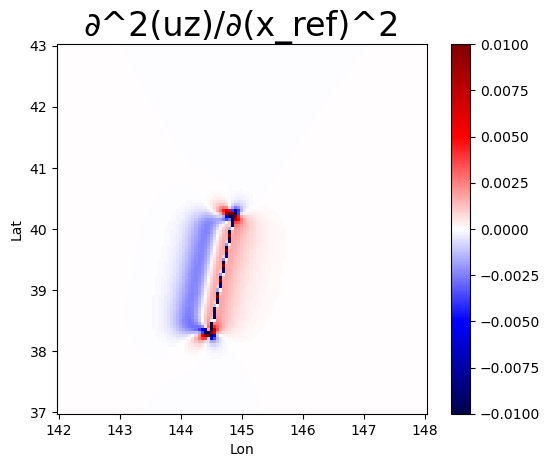

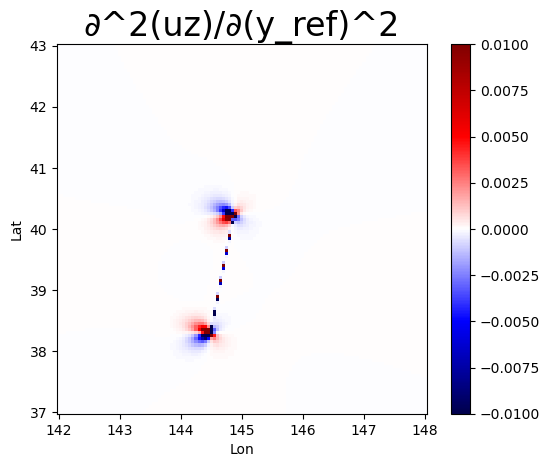

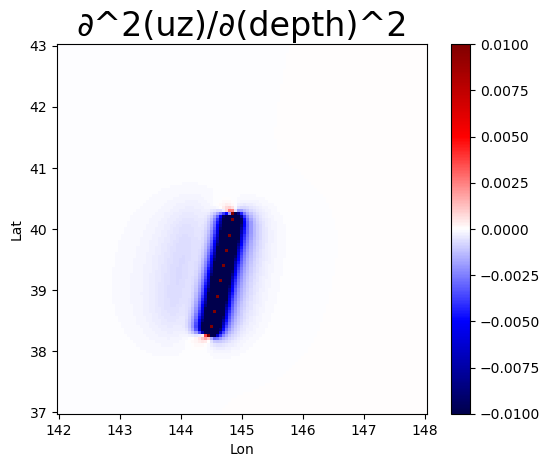

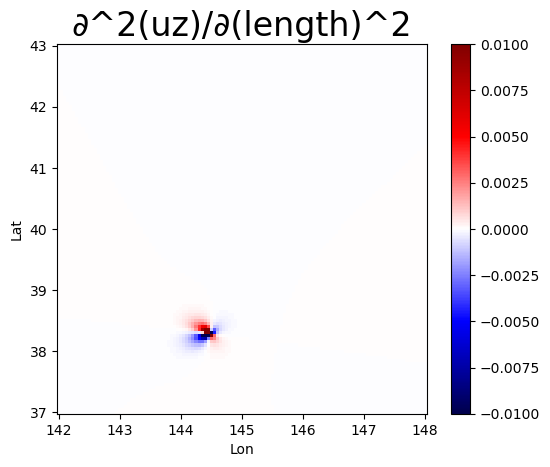

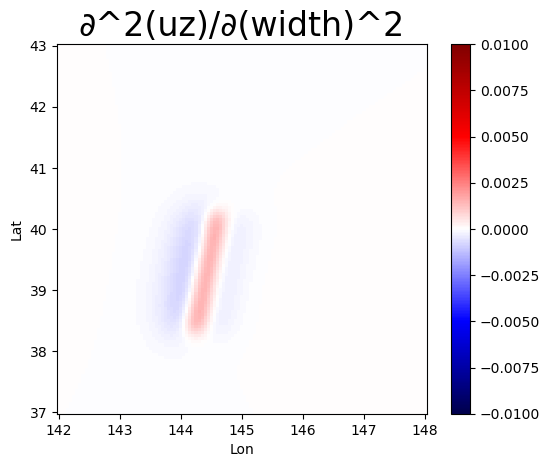

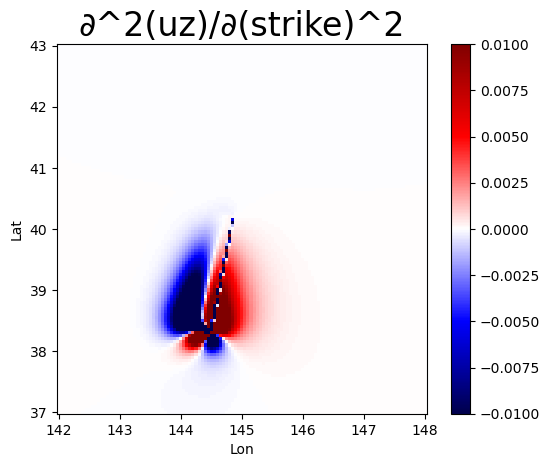

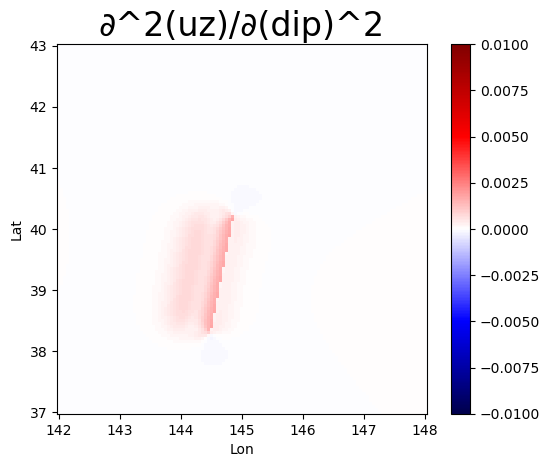

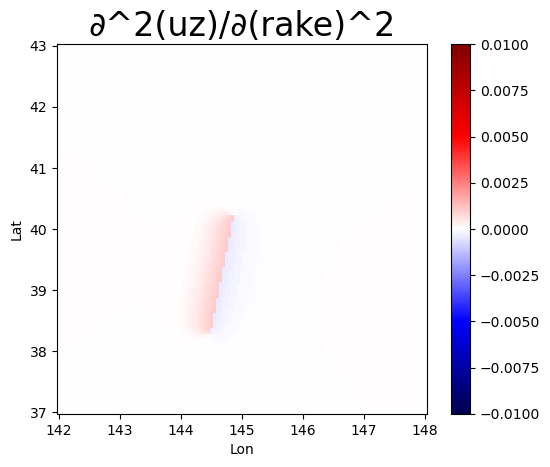

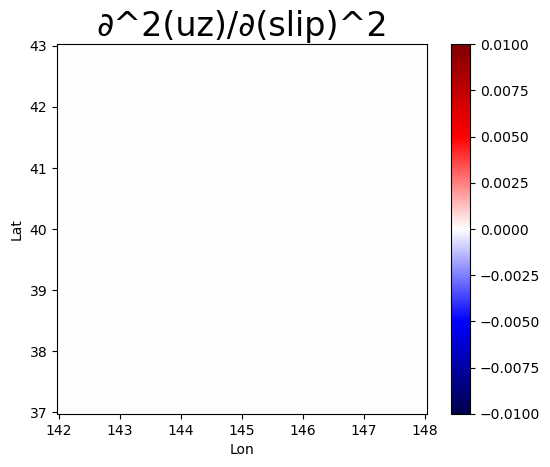

In [16]:
for i, var in enumerate(list(params)):

    _, _, dduz = okada.hessian(coords, params, arg1=var, arg2=var, compute_strain=False, is_degree=True)

    fig, ax = plt.subplots()
    im = ax.pcolormesh(Lon, Lat, dduz.detach().numpy(), cmap="seismic", vmin=-0.01, vmax=0.01)
    ax.set_aspect("equal")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.set_title(f"∂^2(uz)/∂({var})^2", fontsize=24)
    fig.colorbar(im)
    fig.show()